In [ ]:
!pip install fredapi
from fredapi import Fred
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import statsmodels.api as sm
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
fred = Fred(api_key='a03956badb3c532401fb84d2f05cc82b')
df=pd.DataFrame()
df['1m'] = fred.get_series('DGS1MO')
df['3m'] = fred.get_series('DGS3MO')
df['1y'] = fred.get_series('DGS1')
df['2y'] = fred.get_series('DGS2')
df['3y'] = fred.get_series('DGS3')
df['5y'] = fred.get_series('DGS5')
df['7y'] = fred.get_series('DGS7')
df['10y'] = fred.get_series('DGS10')
df['20y'] = fred.get_series('DGS20')
df['30y'] = fred.get_series('DGS30')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5556 entries, 2001-07-31 to 2022-11-15
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1m      5326 non-null   float64
 1   3m      5326 non-null   float64
 2   1y      5326 non-null   float64
 3   2y      5326 non-null   float64
 4   3y      5326 non-null   float64
 5   5y      5326 non-null   float64
 6   7y      5326 non-null   float64
 7   10y     5326 non-null   float64
 8   20y     5326 non-null   float64
 9   30y     5326 non-null   float64
dtypes: float64(10)
memory usage: 477.5 KB


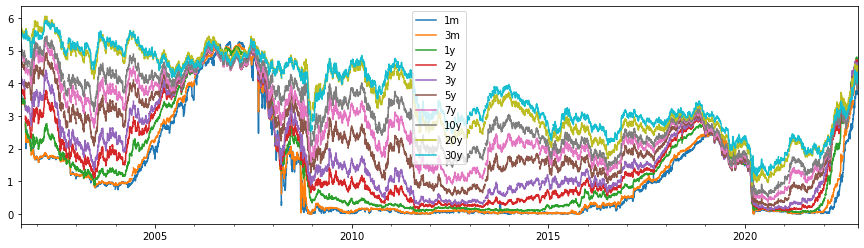

In [ ]:
df.plot(figsize=(15,4))
#df.head()

In [ ]:

reference_curve = 7
cols_to_change = df.keys()[:]
col_reference = df.keys()[reference_curve]

end_pos = len(cols_to_change)
for col in cols_to_change:
  df.insert(end_pos, "level_"+col, df[col])
  end_pos+=1

for col in cols_to_change:
  df[col] = df[col].diff()

for col in cols_to_change:
  if(col != col_reference):
    df[col] = df[col].div(df[col_reference])
df[col_reference] = 1
df_ratios = df.iloc[:,:10]

In [ ]:
df_ratios.replace([df_ratios[df_ratios>3.0]], 3.0, inplace=True)
df_ratios.replace([df_ratios[df_ratios<-3.0]], -3.0, inplace=True)

training_ratios=pd.DataFrame.copy(df_ratios)
test_ratios=pd.DataFrame.copy(df_ratios)
training_ratios = training_ratios.loc[(training_ratios.index <= '2019-09-30')]
test_ratios=test_ratios.loc[(test_ratios.index>'2019-09-30')]

training_ratios.replace([np.inf, -np.inf], np.nan, inplace=True)
training_ratios.interpolate(method='polynomial', order=3, inplace=True)
training_ratios.dropna(inplace=True)

test_ratios.replace([np.inf, -np.inf], np.nan, inplace=True)
test_ratios.interpolate(method='polynomial', order=3, inplace=True)
test_ratios.dropna(inplace=True)

df_ratios.replace([np.inf, -np.inf], np.nan, inplace=True)

df_ratios.interpolate(method='polynomial', order=3, inplace=True)
df_ratios.dropna(inplace=True)
df_ratios[abs(df_ratios)> 3.0].count()/np.shape(df_ratios)[0]*100

1m     8.514851
3m     4.896490
1y     3.168317
2y     4.464446
3y     4.248425
5y     2.286229
7y     1.080108
10y    0.000000
20y    1.566157
30y    3.348335
dtype: float64

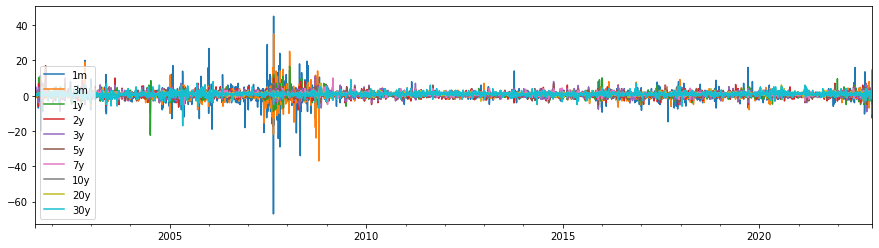

In [ ]:
df_ratios.plot(figsize=(15,4))

In [ ]:
###Scale Inputs###
scaler=StandardScaler()
scaler.fit(df_ratios)
scaled_data=scaler.transform(df_ratios)
print('Original Dimensions',scaled_data.shape[1])

###PCA Dimension Reduction###
pca=PCA(n_components=2)
pca.fit(scaled_data)
x_pca=pca.transform(scaled_data)
print('PCA Reduced Dimensions',x_pca.shape[1])

Original Dimensions 10
PCA Reduced Dimensions 2


Text(0, 0.5, 'Second principle component')

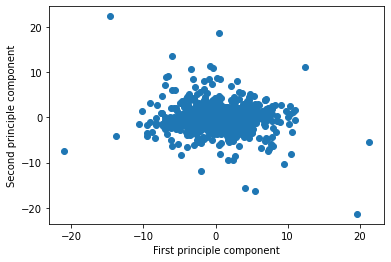

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(x_pca[:,0],x_pca[:,1])
plt.xlabel('First principle component')
plt.ylabel('Second principle component')

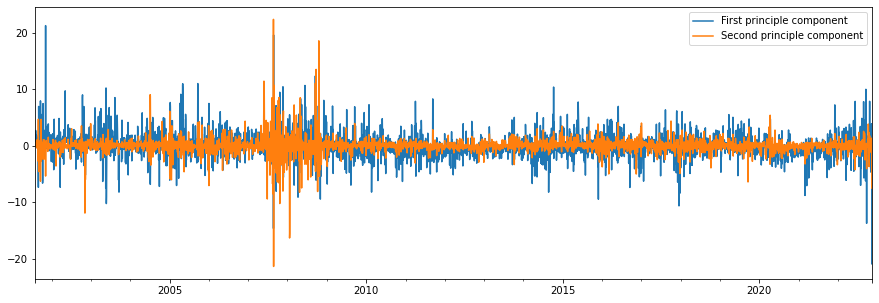

In [ ]:
df_pca=pd.DataFrame(x_pca,index=df_ratios.index,columns=['First principle component','Second principle component'])
df_pca.plot(figsize=(15,5))

In [ ]:
df_pca.tail()

,First principle component,Second principle component
2022-11-09,3.892919,1.336828
2022-11-10,0.322040,0.086478
2022-11-11,-9.509114,-3.440612
2022-11-14,-20.966277,-7.550668
2022-11-15,-0.240585,-0.053065


In [ ]:
from statsmodels.tsa.stattools import adfuller
keys = ['1m','3m','1y','2y','3y','5y','7y','10y','20y','30y']
adfOut = {
    default: {'critical_value':'','p_value':'','lag': '','t_values':'', 'AIC':''}
    for default in keys
}


k=0
for i in range(len(keys)):
    out=adfuller(df_ratios.iloc[:,i])
    adfOut[keys[i]]['critical_value'] = out[0]
    adfOut[keys[i]]['p_value'] = out[1]
    adfOut[keys[i]]['lag'] = out[2]
    adfOut[keys[i]]['t_values'] = out[4]
    adfOut[keys[i]]['AIC'] = out[5]
    k+=1

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


In [ ]:
for i in range(len(keys)):
  print("p value for "+str(keys[i]) )
  print(adfOut[keys[i]]['p_value'])

p value for 1m
2.5470812535968594e-21
p value for 3m
5.6155282672382e-23
p value for 1y
3.917608905388319e-24
p value for 2y
2.5562684581192975e-21
p value for 3y
8.841441940922351e-27
p value for 5y
2.6989081614514057e-15
p value for 7y
0.0
p value for 10y
nan
p value for 20y
2.3313518406868474e-30
p value for 30y
2.0707101166025982e-30


In [ ]:
!pip install pmdarima
import pmdarima
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


0.36184642462911326


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  inferred_freq = False
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  inferred_freq = False
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  maxiter=maxiter,


0.3242816765322896


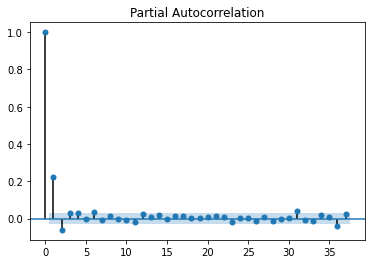

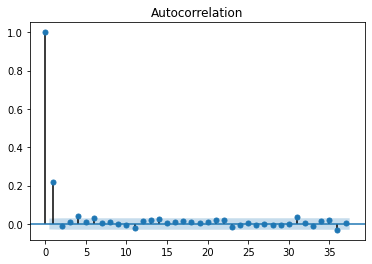

In [ ]:

series7y=training_ratios.iloc[:,6]
series7yTest=test_ratios.iloc[:,6]
plot_pacf(series7y)
#"""Above is the partial autocorrelation for p, below is the autocorrelation for q for MA"""
plot_acf(series7y)

p=[0,1,2,3,4,5]
q=[0,1,2,3,4,5]
#AIC=np.zeros((len(p), len(q)))
#BIC=np.zeros((len(p), len(q)))
#AICC=np.zeros((len(p), len(q)))
#for i in range(len(p)):
 #   for j in range(len(q)):
 #       model=sm.tsa.arima.ARIMA(series7y, order=(p[i],0,q[j]))
  #      model_fit=model.fit()
   #     AIC[i,j]+=model_fit.aic
    #    BIC[i,j]+=model_fit.bic
     #   AICC[i,j]+=model_fit.aicc
#print(np.argwhere(AIC == np.min(AIC)))
#print(np.argwhere(BIC==np.min(BIC)))
#print(np.argwhere(AICC==np.min(AICC)))
#[2,4] for aic, [0,1] for bic, [2,4] for AICC
#print(np.argwhere(AIC+BIC==np.min(AIC+BIC)))
#[0,1] for aic+bic
# test=pmdarima.arima.ARIMA(order=(0,0,1))
# test_fit=test.fit(series7y)
# print(test_fit.aic())

out=pmdarima.arima.auto_arima(series7y,start_p=0, start_q=0,d=0,information_criterion='aicc', max_p=100, max_q=100)
out_fit=out.fit(series7y)
#print(out_fit.aic())

predOut=out.predict(len(series7yTest))
print(metrics.mean_absolute_error(predOut,series7yTest))

model=pmdarima.arima.ARIMA(order=(2,0,4))
model_fit=model.fit(series7y)
predModel=model.predict(len(series7yTest))
print(metrics.mean_squared_error(predModel,series7yTest))
